In [ ]:
import numpy as np
import pandas as pd
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
electronics_data=pd.read_csv("/content/ratings_Electronics (1).csv",names=['userId', 'productId','Rating','timestamp'])

In [ ]:
electronics_data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1.365811e+09
1,A2CX7LUOHB2NDG,0321732944,5.0,1.341101e+09
2,A2NWSAGRHCP8N5,0439886341,1.0,1.367194e+09
3,A2WNBOD3WNDNKT,0439886341,3.0,1.374451e+09
4,A1GI0U4ZRJA8WN,0439886341,1.0,1.334707e+09


In [ ]:
#Shape of the data
electronics_data.shape

(952849, 4)

In [ ]:
#Taking subset of the dataset
electronics_data=electronics_data.iloc[:1048576,0:]

In [ ]:
#Check the datatypes
electronics_data.dtypes

userId        object
productId     object
Rating       float64
timestamp    float64
dtype: object

In [ ]:
electronics_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 952849 entries, 0 to 952848
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     952849 non-null  object 
 1   productId  952849 non-null  object 
 2   Rating     952848 non-null  float64
 3   timestamp  952848 non-null  float64
dtypes: float64(2), object(2)
memory usage: 29.1+ MB


In [ ]:
electronics_data.describe()['Rating'].T

count    952848.000000
mean          3.973175
std           1.400119
min           1.000000
25%           3.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: Rating, dtype: float64

In [ ]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_data.Rating.min()))
print('Maximum rating is: %d' %(electronics_data.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


The rating of the product range from 0 to 1

In [ ]:
print('Number of missing values across columns: \n',electronics_data.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
Rating       1
timestamp    1
dtype: int64


## Ratings

Text(0, 0.5, 'Total number of ratings')

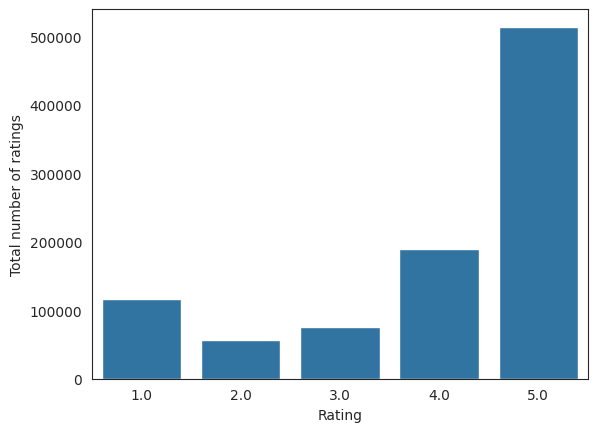

In [ ]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.countplot(x="Rating", data=electronics_data)
    g.set_ylabel("Total number of ratings")

Most of the people has given the rating of 5

## Unique Users and products


In [ ]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",electronics_data.shape[0])
print("Total No of Users   :", len(np.unique(electronics_data.userId)))
print("Total No of products  :", len(np.unique(electronics_data.productId)))

Total data 
--------------------------------------------------

Total no of ratings : 952849
Total No of Users   : 723336
Total No of products  : 56240


## Dropping the TimeStamp Column

In [ ]:
electronics_data.drop(['timestamp'], axis=1,inplace=True)

# Analyzing the rating

In [ ]:
no_of_rated_products_per_user = electronics_data.groupby(by='userId')['Rating'].count().sort_values(ascending=False)
no_of_rated_products_per_user.head()

userId
A5JLAU2ARJ0BO     406
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    163
A6FIAB28IS79      135
AKT8TGIT6VVZ5     120
Name: Rating, dtype: int64

In [ ]:
no_of_rated_products_per_user.describe()

count    723336.000000
mean          1.317297
std           1.354830
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         406.000000
Name: Rating, dtype: float64

In [ ]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

<Figure size 1000x1000 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

<Axes: title={'center': 'Quantiles and their Values'}>

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

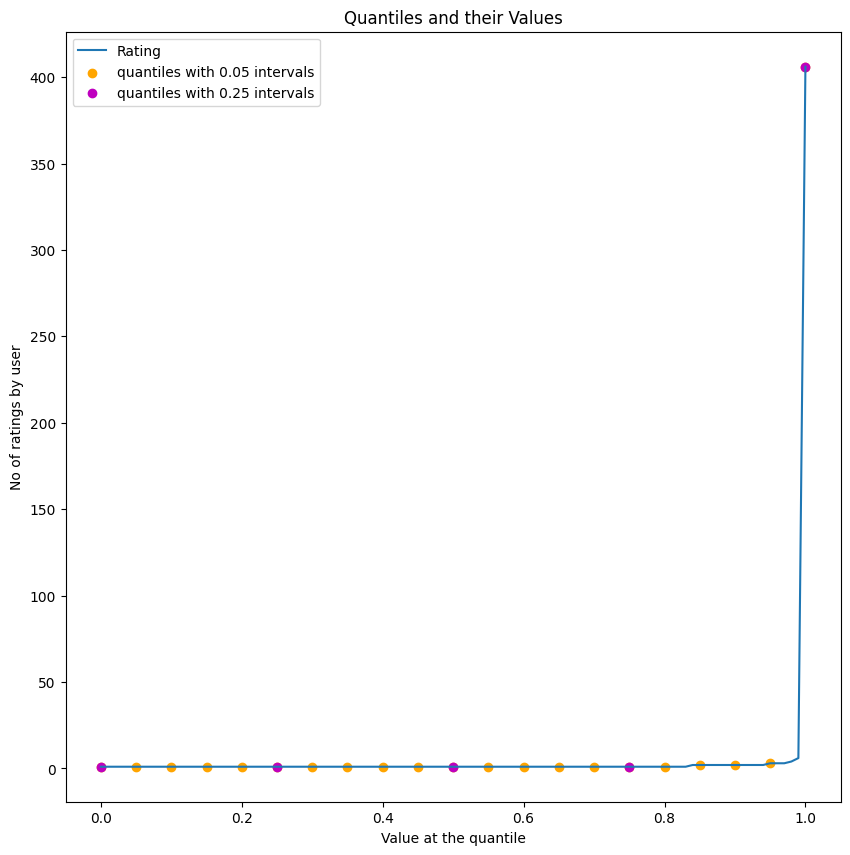

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [ ]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )



 No of rated product more than 50 per user : 35



# Collaberative filtering



In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162997 sha256=40a831a31736af812fb4f1f6cad0ebf804d1db54de70da1fc17b2d4a36599ae0
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [ ]:
new_df=electronics_data.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df,reader)

In [ ]:
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [ ]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [ ]:
test_pred = algo.test(testset)

In [ ]:
test_pred


[Prediction(uid='A3GS1WWUTWEIC7', iid='B0001FTVDQ', r_ui=5.0, est=4.053501158214954, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A3N53T1AMTXDE4', iid='B000BP50AY', r_ui=4.0, est=4.053501158214954, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A2ZRY8VFTFFOMM', iid='B00007E7C8', r_ui=5.0, est=4.053501158214954, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='ANVA8R03LWFVC', iid='B00006JQ06', r_ui=3.0, est=4.053501158214954, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AJYT56M4RWX1B', iid='B000FMPGJ8', r_ui=4.0, est=4.053501158214954, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A138D0DWNR30ON', iid='B000E204LY', r_ui=5.0, est=4.053501158214954, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A3LA00MUHHTI0

In [ ]:
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.3467


1.3466792759991473

# Model-based collaborative filtering system

In [ ]:
new_df1=new_df.head(10000)
ratings_matrix = new_df1.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
userId,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0266076X6KPZ6CCHGVS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0571176384K8RBNKGF8O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
ratings_matrix.shape

(9832, 76)

In [ ]:
X = ratings_matrix.T
X.head()

userId,A01852072Z7B68UHLI5UG,A0266076X6KPZ6CCHGVS,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0571176384K8RBNKGF8O,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A0821988FXKFYX53V4QG,A099626739FNCRNHIKBCG,...,AZWOPBY75SGAM,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXKUK895VGSM,AZXP46IB63PU8,AZYTSU42BZ7TP,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZST8OYL5P4Q
productId,,,,,,,,,,,,,,,,,,,,,
0972683275,0,0,5,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501520,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1400501776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1400532620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X.shape

(76, 9832)

Unique products in subset of data


In [ ]:
X1 = X

In [ ]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(76, 10)

In [ ]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(76, 76)

In [ ]:
X.index[75]


'B00000K135'

Index # of product ID purchased by customer



In [ ]:
i = "B00000K135"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

75

Correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product

In [ ]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(76,)

Recommending top 25 highly correlated products in sequence



In [ ]:
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i)

Recommend[0:24]

['1400501466',
 '1400501520',
 '1400501776',
 '1400532736',
 '1400698987',
 '3744295508',
 '6301977173',
 '8862935293',
 '9888002198',
 '9966694544',
 'B00000J08Q',
 'B00000J1EQ',
 'B00000J1QK',
 'B00000J1V3',
 'B00000J4EY',
 'B00000JBHP']